### importing libraries

In [1]:
from google.cloud import storage
from oauth2client.service_account import ServiceAccountCredentials

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import gspread
gc = gspread.oauth()

import os
import csv
import json
import gzip
import glob

import haversine as hs

from tqdm.notebook import tqdm
tqdm.pandas()

from datetime import datetime, timedelta
from pytz import timezone

### instantiating the google cloud object

In [2]:
# instantiating the google cloud storage client using the credentials
storage_client = storage.Client.from_service_account_json('ds_credentials_edit.json')

### creating a bucket on google cloud storage

In [3]:
# # declaring the bucket name to be created
# bucket_name = 'ds_competitor_1_marketplace_scraped_data'

# # create a new bucket
# new_bucket = storage_client.bucket(bucket_name)
# new_bucket.storage_class = 'STANDARD'

# # returns Bucket object
# created_bucket = storage_client.create_bucket(new_bucket, location='asia-south1')

### calling the google cloud storage bucket object and pushing not yet uploaded files

In [4]:
# declaring the bucket name from which the date needs to be fetched
bucket_name = 'ds_competitor_1_marketplace_scraped_data'

# get the bucket object from the storage_client
bucket = storage_client.get_bucket(bucket_name)

In [5]:
# declaring empty list to store the filenames that needs to be downloaded from the bucket
blob_file_names = []

# get names of all the blobs in the bucket
for blob_ in bucket.list_blobs():
    blob_file_names.append(blob_.name)

In [6]:
# crawling through folder to get all the file names with local directory
local_path = "/home/customer/Narada/ScrapedData"
all_folders = glob.glob(local_path + '/**')
files_uploaded_dir_remote = []
files_uploaded_dir_local = []

while len(all_folders)!=0:
    local_file = all_folders.pop()
    if not os.path.isfile(local_file):
        all_folders.extend(glob.glob(local_file + '/**'))
    else:
        files_uploaded_dir_remote.append(local_file[22:])
        files_uploaded_dir_local.append(local_file)

In [7]:
# creating dataframe for the directory path and file_names
all_file_dir = pd.DataFrame({'remote':files_uploaded_dir_remote,\
                         'local':files_uploaded_dir_local
                        })

In [8]:
# filtering out the files that need to pushed to google cloud storage
file_dir = all_file_dir[~all_file_dir['remote'].isin(blob_file_names)].reset_index(drop=True)

In [9]:
# count of file to be uploaded to google cloud storage
len(file_dir)

0

In [10]:
# iterating and trying to upload all data programatically
for i in tqdm(range(len(file_dir))):
    # Name of the object to be stored in the bucket
    object_name_in_bucket = bucket.blob(file_dir['remote'].iloc[i])
    
    # Name of the object in local file system
    object_name_in_bucket.upload_from_filename(file_dir['local'].iloc[i])

0it [00:00, ?it/s]

### segregating and labelling the files into "Animal Details", "Seller Details" and "Resource Details"

In [11]:
# segragating "Animal Details", "Resources" and "Seller Info" files
def labelling_files(x):
    # handling bad files
    if len(x.split(".")[0])>5:
        # splitting "file name" into 'sub_file_name_tokens'
        sub_file_name_tokens = x.split(".")[0].split("_")

        # getting 'file_type' - AD/seller/resource
        file_type = sub_file_name_tokens[-1]

        # getting 'date_scraped'
        date_scraped = sub_file_name_tokens[-2]

        # getting 'state' (cross checking)
        state = sub_file_name_tokens[0]
        
        # returns data as tuple
        return [file_type, date_scraped, state]

    else:
        return ['NA', 'NA', 'NA']

In [12]:
# getting file_names to segregate and process files
file_names = [item.split("/")[-1] for item in files_uploaded_dir_local]

In [13]:
# dataFrame with details of all the files in our 'ScrapedData' for 'classified' business
file_df = pd.DataFrame({'file_names':file_names,\
                        'location':files_uploaded_dir_local
                       })

In [14]:
# adding metaData to the 'file_df' DataFrame
file_df[['file_type','date_scraped','state']] = file_df['file_names'].progress_apply(lambda x:labelling_files(x)).tolist()

# dropping 'NA' rows
file_df = file_df[file_df['state']!='NA']

# converting 'date_scraped' to datetime format, and sorting dataFrame
file_df['date_scraped'] = pd.to_datetime(file_df['date_scraped'])
file_df.sort_values(by='date_scraped', inplace=True)
file_df.reset_index(drop=True, inplace=True)

  0%|          | 0/827 [00:00<?, ?it/s]

In [15]:
# fetching most recent sample "classified-animal_details" excel file
AD_files = file_df[file_df['file_type']=='AD'].reset_index(drop=True)

# fetching most recent sample "classified-seller" excel file
seller_files = file_df[file_df['file_type']=='seller'].reset_index(drop=True)

# fetching most recent sample "classified-resource" excel file
resource_files = file_df[file_df['file_type']=='resource'].reset_index(drop=True)

### all ANIMAL details files cattle movement analysis

In [16]:
# function to concatenate all "Animal Details" excel files
def get_animal_details(files_df_):
    # declaring empty list to concat all dataFrames
    dflist = []
    
    # looping and concatenating
    for i in tqdm(range(len(files_df_))):#[-10] to take most recent 10 days scraped data
        
        # file_path of all excel files
        file_path_ = files_df_['location'].iloc[i]

        # reading the file        
        df1 = pd.read_excel(file_path_)
        df1['date_scraped'] = files_df_['date_scraped'].iloc[i]
        df1['date_scraped'] = pd.to_datetime(df1['date_scraped'])
        df1['listing_state'] = files_df_['state'].iloc[i]
        df1['file_age'] = df1['date_scraped'].apply(lambda x: int((datetime.today() - x).days)+1)
        dflist.append(df1)
        
    # concatenating and dropping index
    concatenated_df = pd.concat(dflist).reset_index().drop('index',axis=1)
    
    # renaming columns
    concatenated_df.rename(columns={'_id':'cattle_id','userId':'seller_id', 'seller':'seller_name', 'state':'listing_status'}, inplace=True)
    
    # returning the concatenated dataFrame
    return concatenated_df

In [17]:
# # changing the directory to location where excel files will be downloaded
# os.chdir("processed_data_files/")

# # getting list of all downloaded CSV files
# all_processed_files = os.listdir()

# # changing directory to previous folder
# os.chdir("../")

# # reading from disk
# ad_csvs = [item for item in all_processed_files if item[:21]=='all_animal_details_df']
# ad_csvs.sort()
# recent_ad_df = pd.read_csv("processed_data_files/"+ad_csvs[-1], compression='gzip')

In [18]:
# calling the dataFrames concatenating function
all_animal_details_df = get_animal_details(AD_files)

  0%|          | 0/276 [00:00<?, ?it/s]

In [149]:
# # adding date of results to cattle_sold csv file_name
# animal_details_file_name = "processed_data_files/all_animal_details_df_"+str(datetime.today().date())+".csv"

# # saving to disk
# all_animal_details_df.to_csv(animal_details_file_name, index=False, compression='gzip')

In [20]:
# dropping off "PENDING" and "STA" listing_status - only 2 such instances
all_ad_df = all_animal_details_df[all_animal_details_df['listing_status']=='ACTIVE'].copy()

# getting all unique 'cattle_id'
all_ad_df['cattle_id'] = all_ad_df['cattle_id'].astype(str)

# converting columns into 'datetime' format
all_ad_df['publishedOn'] = pd.to_datetime(all_ad_df['publishedOn'])
all_ad_df['date_scraped'] = pd.to_datetime(all_ad_df['date_scraped'])

# getting the 'last_scraped_date'
last_scraped_date = all_ad_df['date_scraped'].max()

In [21]:
# replacing NaN values
all_ad_df['description'].fillna("-", inplace=True)
all_ad_df['deliveredBefore'].fillna(-999, inplace=True)
all_ad_df['hasDelivered'].fillna(-999, inplace=True)
all_ad_df['isPregnant'].fillna(-999, inplace=True)
all_ad_df['pregnancyMonth'].fillna(-999, inplace=True)
all_ad_df['calf'].fillna('-', inplace=True)
all_ad_df['partnerId'].fillna(-999, inplace=True)
all_ad_df['hasContacted'].fillna(-999, inplace=True)
all_ad_df['breed'].fillna("-", inplace=True)

# replacing int 0 value with str
all_ad_df['calf'].replace(0,'-', inplace=True)
all_ad_df['breed'].replace(0,'-', inplace=True)

# dropping redundant columns
all_ad_df.drop(columns=['description'], inplace=True)
all_ad_df.drop(columns=['district'], inplace=True)
all_ad_df.drop(columns=['dynamicLink'], inplace=True)

In [22]:
# grouped based on "cattle_id", sorted by "date_scraped", taking the last occurence
cattle_sold = pd.DataFrame(all_ad_df.sort_values(by='date_scraped').groupby('cattle_id').tail(1)).reset_index(drop=True)


In [23]:
# converting datetime utc to datetime ist
cattle_sold['publishedOn'] = cattle_sold['publishedOn'].progress_apply(lambda x: x.astimezone(timezone('Asia/Kolkata')))


  0%|          | 0/108638 [00:00<?, ?it/s]

In [24]:
# rounding off to 6 digit decimal
cattle_sold['lat'] = cattle_sold['lat'].round(6)
cattle_sold['long'] = cattle_sold['long'].round(6)

In [25]:
# lat,long pair
cattle_sold['lat_long'] = cattle_sold.progress_apply(lambda x: str(x['lat'])+","+str(x['long']), axis=1)

  0%|          | 0/108638 [00:00<?, ?it/s]

In [26]:
# function to get listing_status(Sold/Unsold/Fresh_listing) an the no. of days taken to sell item if sold
def get_listing_status(x, last_scraped_dt):
    # "UnSold" listing
    if int((last_scraped_dt-pd.to_datetime(x['date_scraped'])).days)==0:
        days_to_sell = -999
        sold_status = 'UNSOLD'
    # "Fresh" listing
    elif int((last_scraped_dt-pd.to_datetime(x['publishedOn'].date())).days)==0:
        days_to_sell = -999
        sold_status = 'FRESH_LISTING'
    # "De-listed" listing
    elif int((pd.to_datetime(x['date_scraped'])-pd.to_datetime(x['publishedOn'].date())).days)==28:
        days_to_sell = -999
        sold_status = 'DELISTED_LISTING'
    # "Sold" listing
    else:
        days_to_sell = int((pd.to_datetime(x['date_scraped'])-pd.to_datetime(x['publishedOn'].date())).days)+1
        sold_status = 'Yes'
     
    # returning the no. of "days_taken_to_sell" and the final "sold_status"
    return [days_to_sell, sold_status]

In [27]:
# applying the "get_listing_status" function
cattle_sold[['days_to_sell', 'sold_status']] = cattle_sold.progress_apply(lambda y:get_listing_status(y, last_scraped_date),axis=1).tolist()

  0%|          | 0/108638 [00:00<?, ?it/s]

<AxesSubplot: title={'center': 'day_to_sell distribution'}, xlabel='days_to_sell', ylabel='# sold'>

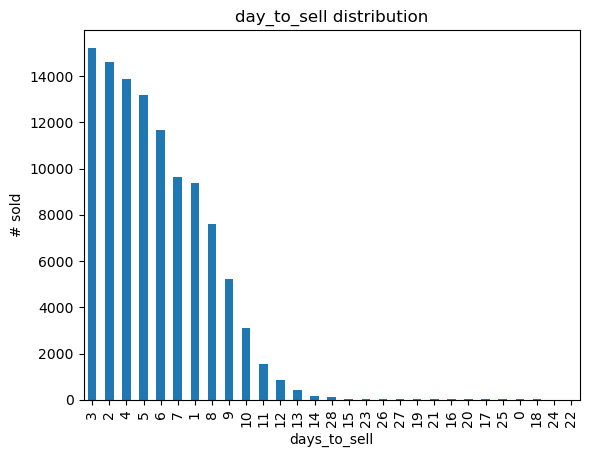

In [28]:
cattle_sold[cattle_sold['days_to_sell']!=-999]['days_to_sell'].value_counts().plot.bar(xlabel="days_to_sell",ylabel="# sold", title="day_to_sell distribution")

In [29]:
cattle_sold.shape

(108638, 38)

In [30]:
# # adding date of results to cattle_sold csv file_name
# cattle_sold_file_name = "processed_data_files/cattle_sold_df_"+str(datetime.today().date())+".parquet"

# # saving to disk
# cattle_sold.to_parquet(cattle_sold_file_name, index=False)

In [31]:
# unique_lat_loong for gmap lat_long mapping
unique_lat_long_df = cattle_sold[['lat','long','lat_long']].drop_duplicates(subset=['lat_long'], keep='last').reset_index(drop=True)


### all SELLER details files contact number mapping

In [32]:
# function to concatenate all "Seller" excel files
def get_seller_details(files_df_):
    # declaring empty list to concat all dataFrames
    dflist = []
    
    # looping and concatenating
    for i in tqdm(range(len(files_df_))):#[-10] to take most recent 10 days scraped data
        
        # file_path of all excel files
        file_path_ = files_df_['location'].iloc[i]
        
        # reading the file
        df1 = pd.read_excel(file_path_)
        df1['date_scraped'] = files_df_['date_scraped'].iloc[i]
        df1['date_scraped'] = pd.to_datetime(df1['date_scraped'])
        df1['listing_state'] = files_df_['state'].iloc[i]
        df1['file_age'] = df1['date_scraped'].apply(lambda x: int((datetime.today() - x).days)+1)
        dflist.append(df1)
        
    # concatenating and dropping index
    concatenated_df = pd.concat(dflist).reset_index().drop('index',axis=1)
    
    # renaming columns
    concatenated_df.rename(columns={'_id':'cattle_id','userId':'seller_id', 'seller':'seller_name', 'state':'listing_status'}, inplace=True)
    
    # returning the concatenated dataFrame
    return concatenated_df

In [33]:
# # changing the directory to location where excel files will be downloaded
# os.chdir("processed_data_files/")

# # getting list of all downloaded CSV files
# all_processed_files = os.listdir()

# # changing directory to previous folder
# os.chdir("../")

# # reading from disk
# seller_parquets = [item for item in all_processed_files if item[:21]=='all_seller_details_df']
# seller_parquets.sort()
# recent_seller_df = pd.read_parquet("processed_data_files/"+seller_parquets[-1])

In [34]:
# calling the dataFrames concatenating function
all_seller_details_df = get_seller_details(seller_files)

  0%|          | 0/275 [00:00<?, ?it/s]

In [35]:
# tagging and filtering out 10 digit seller_id
all_seller_details_df['contact_number_y/n'] = all_seller_details_df['id'].progress_apply(lambda x: "Yes" \
                                                                                if(len(str(x))==10) else "No")

  0%|          | 0/530689 [00:00<?, ?it/s]

In [36]:
all_contacts = all_seller_details_df[all_seller_details_df['contact_number_y/n'] == 'Yes'].reset_index(drop=True).copy()

In [37]:
contacts_cattle_id = all_contacts[['cattle_id','id']].copy()
contacts_cattle_id.rename(columns={'id':'contact_number'}, inplace=True)
contacts_cattle_id['contact_number'] = contacts_cattle_id['contact_number'].astype(int)
contacts_cattle_id.drop_duplicates(inplace=True)
contacts_cattle_id.reset_index(drop=True, inplace=True)

In [38]:
contacts_cattle_id.shape

(25552, 2)

In [39]:
# # adding date of results to all_animal_details csv file_name
# contacts_cattle_id_file_name = "processed_data_files/all_seller_details_df_"+str(datetime.today().date())+".parquet"

# # saving to disk
# contacts_cattle_id.to_parquet(contacts_cattle_id_file_name, index=False)

### all cattles pincode mapping - gmap_lat_long

In [52]:
# # 'new' from 'gmap_lat_long_mapping'
# sh = gc.open_by_key('1yybUEyelVjqX4AfwRqgRJ4EK19CakSNVaFHkCqzZ8PA')
# res = sh.values_get("new!A:H")
# gmap_lat_long_mapping_df = pd.DataFrame(res['values'][1:], columns=res['values'][0]) 

In [83]:
# reading the current gmap_lat_long_mapping csv
gmap_lat_long_mapping_df = pd.read_csv("gmap_mapping_result.csv")

In [84]:
gmap_lat_long_mapping_df.shape

(55179, 8)

In [85]:
gmap_lat_long_mapping_df.head()

,lat,long,lat_long,GLat,GLong,lat_long_gmap,Pincode,Distance
0,23.2432,82.8425,"23.2432,82.8425",23.2878,82.1659,"23.2878,82.1659",484440,83.151
1,23.4886,83.7164,"23.4886,83.7164",24.0249,83.2452,"24.0249,83.2452",231212,91.826
2,23.8331,79.4419,"23.8331,79.4419",23.8323,79.4387,"23.8323,79.4387",470661,0.410
3,23.6399,79.0655,"23.6399,79.0655",23.6399,79.0655,"23.6399,79.0655",470227,0.001
4,23.8235,79.4294,"23.8235,79.4294",23.8189,79.4288,"23.8189,79.4288",470661,0.623


In [86]:
unique_lat_long_df.shape

(54832, 3)

In [87]:
# filtering out 'cattle_ids' that need to be mapped
tbd_df = unique_lat_long_df[~unique_lat_long_df['lat_long'].isin(gmap_lat_long_mapping_df['lat_long'].tolist())].reset_index(drop=True)


In [88]:
tbd_df.shape

(0, 3)

In [89]:
# # Written to "classified_AD_movement_analysis"
# worksheet = gc.open_by_key('1yybUEyelVjqX4AfwRqgRJ4EK19CakSNVaFHkCqzZ8PA').worksheet('tbd_cattles')
# # raw_data
# tbd_cattles_data = [tbd_df.columns.astype(str).tolist()]+tbd_df.values.astype(str).tolist()
# # writing the sheet
# worksheet.update('A1', tbd_cattles_data)

In [90]:
# reading the GMAP lat_long data
lat_long_df = pd.read_csv("GMAP_full.csv")

# unique gmap lat_long from haversine pairing
gmap_data = lat_long_df[['Lat_GMAP','Long_GMAP','Lat_Long_GMAP','Pincode']].to_numpy()

In [91]:
lat_long_df.head()

,OfficeName,Pincode,District,StateName,Lat_GMAP,Long_GMAP,Lat_Long_GMAP
0,Baniya Khera B.O,126110,JIND,HARYANA,29.401032,76.486672,"29.401032,76.486672"
1,Lajwan Kalan B.O,126101,JIND,HARYANA,29.117692,76.433170,"29.117692,76.43317"
2,Malwi B.O,126101,JIND,HARYANA,29.117692,76.433170,"29.117692,76.43317"
3,Mandi Kalan B.O,126125,JIND,HARYANA,29.575578,76.304385,"29.575578,76.304385"
4,Sandil B.O,126125,JIND,HARYANA,29.547268,76.346362,"29.547268,76.346362"


In [92]:
# return min distance and pincode along with gmap mapped lat and long
def gmap_lat_long_mapping_fx(x,y=gmap_data):
    mapped_lat_long_ = []
    distances_ = np.array(list(map(lambda y:hs.haversine((x[0],x[1]),(y[0],y[1])),y)))
    index_min = np.argmin(distances_)
    mapped_lat_long_ = x.tolist()+y[index_min].tolist()+[distances_[index_min].round(3)]
    return mapped_lat_long_

In [93]:
tbd_df.progress_apply(lambda x: gmap_lat_long_mapping_fx(x), axis=1)

0it [00:00, ?it/s]

,lat,long,lat_long


In [94]:
mapped_gmap_data = tbd_df.progress_apply(lambda x: gmap_lat_long_mapping_fx(x), axis=1)

0it [00:00, ?it/s]

In [95]:
mapped_data_df = pd.DataFrame(mapped_gmap_data.values.tolist(), columns=['lat','long','lat_long','GLat','GLong','lat_long_gmap','Pincode','Distance'])


In [96]:
mapped_data_df.shape

(0, 8)

In [97]:
gmap_lat_long_mapping_df = pd.concat([gmap_lat_long_mapping_df,mapped_data_df], axis=0)

In [98]:
gmap_lat_long_mapping_df.shape

(55179, 8)

In [99]:
# rounding off to 6 decimal
gmap_lat_long_mapping_df['lat'] = gmap_lat_long_mapping_df['lat'].astype(float).round(6)
gmap_lat_long_mapping_df['long'] = gmap_lat_long_mapping_df['long'].astype(float).round(6)
gmap_lat_long_mapping_df['Pincode'] = gmap_lat_long_mapping_df['Pincode'].astype(int)
gmap_lat_long_mapping_df['Distance'] = gmap_lat_long_mapping_df['Distance'].astype(float).round(3)

In [100]:
# # Written to "classified_AD_movement_analysis"
# worksheet = gc.open_by_key('1yybUEyelVjqX4AfwRqgRJ4EK19CakSNVaFHkCqzZ8PA').worksheet('current')
# # raw_data
# lat_long_data = [gmap_lat_long_mapping_df.columns.astype(str).tolist()]+gmap_lat_long_mapping_df.values.astype(str).tolist()
# # writing the sheet
# worksheet.update('A1', lat_long_data)

In [101]:
# # Written to "classified_AD_movement_analysis"
# worksheet = gc.open_by_key('1yybUEyelVjqX4AfwRqgRJ4EK19CakSNVaFHkCqzZ8PA').worksheet('new')
# # raw_data
# lat_long_data = [gmap_lat_long_mapping_df.columns.astype(str).tolist()]+gmap_lat_long_mapping_df.values.astype(str).tolist()
# # writing the sheet
# worksheet.update('A1', lat_long_data)

In [102]:
# # adding date of results to all_animal_details csv file_name
# gmap_lat_long_file_name = "processed_data_files/gmap_lat_long_mapping_df_"+str(datetime.today().date())+".parquet"

# # saving to disk
# gmap_lat_long_mapping_df.to_parquet(gmap_lat_long_file_name, index=False)

In [103]:
# # saving to disk
# gmap_lat_long_mapping_df.to_csv("gmap_mapping_result.csv", index=False)

### indian postal code pincode.csv

In [104]:
# reading csv
pincode_df = pd.read_csv("pincode.csv", low_memory=False)

In [105]:
pincode_df.shape

(157126, 11)

In [106]:
pincodes_df = pincode_df[['Pincode','District','StateName']].copy()

In [107]:
pincodes_df = pincodes_df.rename(columns={'Pincode':'gmap_pincode',\
                            'District':'gmap_district',\
                            'StateName':'gmap_state',\
                           })

In [108]:
pincodes_df = pincodes_df.drop_duplicates(subset=['gmap_pincode']).reset_index(drop=True)

In [109]:
pincodes_df.shape

(19300, 3)

### adding features for reports/analysis

#### contacts mapping

In [110]:
cattle_sold.shape

(108638, 38)

In [111]:
contacts_cattle_id.shape

(25552, 2)

In [112]:
cattle_sold = cattle_sold.merge(contacts_cattle_id, left_on='cattle_id', right_on='cattle_id', how='left').fillna(-999)


In [113]:
cattle_sold['contact_number'] = cattle_sold['contact_number'].astype(int)

In [114]:
cattle_sold.shape

(108638, 39)

#### gmap lat long mapping

In [118]:
gmap_lat_long_df = gmap_lat_long_mapping_df[['lat_long','GLat','GLong','lat_long_gmap','Pincode','Distance']].copy()

In [119]:
gmap_lat_long_df = gmap_lat_long_df.rename(columns={'Pincode':'gmap_pincode',\
                                 'GLong':'gmap_long',\
                                 'GLat':'gmap_lat',\
                                })

In [121]:
cattle_sold = cattle_sold.merge(gmap_lat_long_df, left_on='lat_long', right_on='lat_long', how='left').fillna(-999)

In [122]:
cattle_sold['gmap_pincode'] = cattle_sold['gmap_pincode'].astype(int)

In [123]:
cattle_sold.shape

(108638, 44)

#### pincode state and district mapping

In [125]:
cattle_sold.shape

(108638, 44)

In [126]:
cattle_sold = cattle_sold.merge(pincodes_df, left_on='gmap_pincode', right_on='gmap_pincode', how='left').fillna('-')

In [128]:
cattle_sold['gmap_lat_long'] = cattle_sold.apply(lambda x: str(x['gmap_lat'])+","+str(x['gmap_long']), axis=1)
cattle_sold['gmap_district_state'] = cattle_sold.apply(lambda x: str(x['gmap_district'])+","+str(x['gmap_state']), axis=1)
cattle_sold['gmap_pincode_district_state'] = cattle_sold.apply(lambda x: str(x['gmap_pincode'])+","+str(x['gmap_district'])+","+str(x['gmap_state']), axis=1)


In [129]:
cattle_sold = cattle_sold.reset_index(drop=True)

In [130]:
cattle_sold.shape

(108638, 49)

#### adding week names and date features

In [131]:
cattle_sold.shape

(108638, 49)

In [132]:
cattle_sold['month_of_sale'] = cattle_sold['date_scraped'].dt.month_name()
cattle_sold['week_of_sale'] = (cattle_sold['date_scraped']+pd.DateOffset(1)).dt.isocalendar().week
cattle_sold['year_of_sale'] = cattle_sold['date_scraped'].dt.year
cattle_sold['weekday'] = cattle_sold['date_scraped'].dt.strftime('%A')
cattle_sold['week_start_date'] = cattle_sold['date_scraped'].apply(lambda x: (x-timedelta(days=(x.weekday()+1)%7)).strftime('%d %b'))
cattle_sold['week_end_date'] = cattle_sold['date_scraped'].apply(lambda x: (x-timedelta(days=(x.weekday()+1)%7) + timedelta(days=6)).strftime('%d %b'))
cattle_sold['sale_week'] = cattle_sold.apply(lambda x: str(x['week_start_date']) + " - " + str(x['week_end_date']), axis=1)
cattle_sold['sale_day'] = cattle_sold['date_scraped'].apply(lambda x: str(x.strftime('%d %b')) + ": " + str(x.strftime('%a')))
cattle_sold['business_week_name'] = cattle_sold.apply(lambda x: str(x['week_of_sale'])+": "+str(x['sale_week']), axis=1)


In [133]:
cattle_sold.shape

(108638, 58)

#### renaming and standardizing the column names

In [134]:
# making a copy of the dataframe
data = cattle_sold.copy()

In [135]:
# standardizing column names for google cloud storage
col_names_mapping = {'viewCount':'view_count_animall',\
                     'callCount':'call_count_animall',\
                     '_score':'score',\
                     'long':'listing_long',\
                     'lat':'listing_lat',\
                     'highestMilk':'highest_milk',\
                     'locationName':'location_name',\
                     'isNegotiable':'is_negotiable',\
                     'publishedOn':'published_on',\
                     'currentMilk':'current_milk',\
                     'deliveredBefore':'delivered_before',\
                     'hasDelivered':'has_delivered',\
                     'isPregnant':'is_pregnant',\
                     'pregnancyMonth':'pregnancy_month',\
                     'age':'cattle_age',\
                     'animalType':'animal_type',\
                     'partnerId':'partner_id',\
                     'hasContacted':'has_contacted',\
                    }

In [136]:
# renaming columns
data = data.rename(columns=col_names_mapping)

#### standardizing the column data types

In [137]:
data['distance'] = data['distance'].astype(float)
data['rating'] = data['rating'].astype(float)
data['view_count_animall'] = data['view_count_animall'].astype(int)
data['call_count_animall'] = data['call_count_animall'].astype(int)
data['recency'] = data['recency'].astype(int)
data['score'] = data['score'].astype(float)
data['listing_long'] = data['listing_long'].astype(float)
data['listing_lat'] = data['listing_lat'].astype(float)
data['highest_milk'] = data['highest_milk'].astype(float)
data['is_negotiable'] = data['is_negotiable'].astype(int)
data['published_on'] = pd.to_datetime(data['published_on'])
data['current_milk'] = data['current_milk'].astype(float)
data['delivered_before'] = data['delivered_before'].apply(lambda x: float(x) if x!='-' else x)
data['has_delivered'] = data['has_delivered'].apply(lambda x: float(x) if x!='-' else x)
data['is_pregnant'] = data['is_pregnant'].apply(lambda x: float(x) if x!='-' else x)
data['pregnancy_month'] = data['pregnancy_month'].apply(lambda x: float(x) if x!='-' else x)
data['price'] = data['price'].astype(float)
data['cattle_age'] = data['cattle_age'].astype(float)
data['lactation'] = data['lactation'].astype(int)
data['date_scraped'] = pd.to_datetime(data['date_scraped'])
data['file_age'] = data['file_age'].astype(int)
data['days_to_sell'] = data['days_to_sell'].apply(lambda x: int(x) if len(str(x))<=2 else x)
data['week_of_sale'] = data['week_of_sale'].apply(lambda x: int(x) if x!='UNSOLD' else x)
data['year_of_sale'] = data['year_of_sale'].apply(lambda x: int(x) if x!='UNSOLD' else x)
data['gmap_pincode'] = data['gmap_pincode'].apply(lambda x: int(x) if x!='-' else x)
data['contact_number'] = data['contact_number'].apply(lambda x: int(x) if x not in ['NA','-'] else x)

### converting to parquet

In [138]:
data.to_parquet('furnished_data/cattle_sold_data.parquet', index=False)

### creating a bucket on google cloud storage for final furnished data

In [139]:
# # declaring the bucket name to be created
# bucket_name = 'ds_competitor_1_marketplace_reporting'

# # create a new bucket
# new_bucket = storage_client.bucket(bucket_name)
# new_bucket.storage_class = 'STANDARD'

# # returns Bucket object
# created_bucket = storage_client.create_bucket(new_bucket, location='asia-south1')

### pushing to google cloud storage bucket

In [140]:
# declaring the bucket name from which the date needs to be fetched
bucket_name = 'ds_competitor_1_marketplace_reporting'

# get the bucket object from the storage_client
bucket = storage_client.get_bucket(bucket_name)

In [141]:
# Name of the object to be stored in the bucket
object_name_in_bucket = bucket.blob('movement_analysis.parquet')

# local folder name
local_folder = os.getcwd()

# local file location
filename = "%s/%s" % (local_folder, 'furnished_data/cattle_sold_data.parquet')

# Name of the object in local file system
object_name_in_bucket.upload_from_filename(filename)

### reading parquet file

In [142]:
movement_analysis_df = pd.read_parquet('furnished_data/cattle_sold_data.parquet', engine='fastparquet')

In [143]:
movement_analysis_df.shape

(108638, 58)

In [144]:
movement_analysis_df.sample(5)

,cattle_id,seller_id,distance,rating,view_count_animall,call_count_animall,recency,score,listing_long,listing_lat,gender,listing_status,highest_milk,seller_name,location_name,is_negotiable,published_on,current_milk,delivered_before,has_delivered,is_pregnant,pregnancy_month,price,cattle_age,animal_type,breed,calf,lactation,partner_id,has_contacted,type,coordinates,date_scraped,listing_state,file_age,lat_long,days_to_sell,sold_status,contact_number,gmap_lat,gmap_long,lat_long_gmap,gmap_pincode,Distance,gmap_district,gmap_state,gmap_lat_long,gmap_district_state,gmap_pincode_district_state,month_of_sale,week_of_sale,year_of_sale,weekday,week_start_date,week_end_date,sale_week,sale_day,business_week_name
31497,62f8db65f9a6e7000b9f0486,15500677950,10814.0,2.00,8,0,5,92.283598,74.8571,28.1716,FEMALE,ACTIVE,15.0,Madosingh,"सुरतपुरा, Churu Tehsil, Churu, राजस्थान",1,2022-08-14 16:57:26.810000+05:30,0.0,-999.0,0.0,1.0,9.0,90000.0,0.0,BUFFALO,MURRAH CROSS,-,4,-999.0,-999.0,0,0,2022-08-20,RAJASTHAN,41,"28.1716,74.8571",7,Yes,-999,28.1788,74.8683,"28.1788,74.8683",331022,1.626,CHURU,RAJASTHAN,"28.1788,74.8683","CHURU,RAJASTHAN","331022,CHURU,RAJASTHAN",August,33,2022,Saturday,14 Aug,20 Aug,14 Aug - 20 Aug,20 Aug: Sat,33: 14 Aug - 20 Aug
64860,6316f2c2595b58000aa25520,15506060828,38481.0,4.08,33,0,2,89.863110,74.6869,29.1767,FEMALE,ACTIVE,7.0,AnilSinwar,"Sonri, Nohar Tehsil, Hanumangarh District, Raj...",0,2022-09-07 09:52:22.507000+05:30,7.0,-999.0,-999.0,-999.0,-999.0,15000.0,5.0,COW,DESI,-,3,-999.0,-999.0,0,0,2022-09-10,HARYANA,20,"29.1767,74.6869",4,Yes,-999,29.1767,74.6869,"29.1767,74.6869",335523,0.005,HANUMANGARH,RAJASTHAN,"29.1767,74.6869","HANUMANGARH,RAJASTHAN","335523,HANUMANGARH,RAJASTHAN",September,36,2022,Saturday,04 Sep,10 Sep,04 Sep - 10 Sep,10 Sep: Sat,36: 04 Sep - 10 Sep
45864,630441e2a8de2c000ba14c57,15505065794,45111.0,3.73,3,1,7,84.544794,81.7915,25.0605,FEMALE,ACTIVE,0.0,Umakant yadav,"Koraon, प्रयागराज, उत्तर प्रदेश 212306",0,2022-08-23 12:16:41.403000+05:30,4.5,-999.0,-999.0,-999.0,-999.0,55000.0,0.0,BUFFALO,KUNDI,-,3,-999.0,-999.0,0,0,2022-08-30,UTTAR PRADESH,31,"25.0605,81.7915",8,Yes,-999,25.0343,81.7596,"25.0343,81.7596",212106,5.211,PRAYAGRAJ,UTTAR PRADESH,"25.0343,81.7596","PRAYAGRAJ,UTTAR PRADESH","212106,PRAYAGRAJ,UTTAR PRADESH",August,35,2022,Tuesday,28 Aug,03 Sep,28 Aug - 03 Sep,30 Aug: Tue,35: 28 Aug - 03 Sep
108151,63314c855eb190000afdad3a,15504228723,24107.0,4.47,51,5,1,92.422671,76.5719,28.9034,FEMALE,ACTIVE,12.0,Rajiv,"Rohtak, Haryana, 124001, India",0,2022-09-27 14:35:19.677000+05:30,12.0,-999.0,-999.0,-999.0,-999.0,87000.0,6.0,BUFFALO,MURRAH,-,3,-999.0,-999.0,0,0,2022-09-29,HARYANA,1,"28.9034,76.5719",-999,UNSOLD,-999,28.8994,76.5532,"28.8994,76.5532",124001,2.242,ROHTAK,HARYANA,"28.8994,76.5532","ROHTAK,HARYANA","124001,ROHTAK,HARYANA",September,39,2022,Thursday,25 Sep,01 Oct,25 Sep - 01 Oct,29 Sep: Thu,39: 25 Sep - 01 Oct
55719,630d7a8c80998e000b4de8c5,15504175409,12491.0,3.80,87,12,5,91.533252,77.7690,28.8830,FEMALE,ACTIVE,3.0,yahyayahya,"मेरठ, Meerut, मेरठ, उत्तर प्रदेश 250001",1,2022-08-31 07:47:21.997000+05:30,3.0,-999.0,-999.0,-999.0,-999.0,40000.0,0.0,BUFFALO,MURRAH CROSS,-,2,-999.0,-999.0,0,0,2022-09-05,UTTAR PRADESH,25,"28.883,77.769",6,Yes,-999,28.8645,77.7468,"28.8645,77.7468",245206,3.580,MEERUT,UTTAR PRADESH,"28.8645,77.7468","MEERUT,UTTAR PRADESH","245206,MEERUT,UTTAR PRADESH",September,36,2022,Monday,04 Sep,10 Sep,04 Sep - 10 Sep,05 Sep: Mon,36: 04 Sep - 10 Sep
